In [ ]:
# Yelp Dataset Analysis in Google Colab

### Step 1: Setup and Installation

In [ ]:

# Install required packages
!pip install kagglehub pandas numpy seaborn matplotlib

# Import libraries
import os
import re
import gc  # Garbage collection
import pandas as pd
import numpy as np
import kagglehub
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Download the dataset
path = kagglehub.dataset_download("yelp-dataset/yelp-dataset")
print("Path to dataset files:", path)

# List the contents of the directory to check if files are present and correctly named
!ls {path}

# Construct the correct file paths
# Note: Assuming the files are directly within the path, adjust if they are in subdirectories.
business_json_path = os.path.join(path, 'yelp_academic_dataset_business.json')
review_json_path = os.path.join(path, 'yelp_academic_dataset_review.json')

Path to dataset files: /root/.cache/kagglehub/datasets/yelp-dataset/yelp-dataset/versions/4
Dataset_User_Agreement.pdf	     yelp_academic_dataset_review.json
yelp_academic_dataset_business.json  yelp_academic_dataset_tip.json
yelp_academic_dataset_checkin.json   yelp_academic_dataset_user.json


### Step 2: Initial Exploration

In [ ]:

# Load a small sample from the datasets
business_sample = pd.read_json(business_json_path, lines=True, nrows=1000)
review_sample = pd.read_json(review_json_path, lines=True, nrows=1000)

# Display the schema and sample data
print("Business dataset columns:", business_sample.columns)
print("Review dataset columns:", review_sample.columns)

# Check a sample of data
print("\nSample Businesses:")
print(business_sample.head())

print("\nSample Reviews:")
print(review_sample.head())

# Display basic statistics
print("\nBusiness dataset summary:")
print(business_sample.describe(include='all'))
print("\nReview dataset summary:")
print(review_sample.describe(include='all'))

Business dataset columns: Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')
Review dataset columns: Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

Sample Businesses:
              business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   
2             5255 E Broadway Blvd         Tucson 

### Step 3: Configuration and Utility Functions

In [ ]:

# Configuration
CHUNK_SIZE = 10000
SAMPLE_RATE = 0.01  # Sample 1% for quick insights
RANDOM_SEED = 42

# Utility functions
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        return text.lower()
    return ''

def assign_sentiment(stars):
    if stars <= 2:
        return 'negative'
    elif stars == 3:
        return 'neutral'
    else:
        return 'positive'

def analyze_categories(categories_series):
    categories = categories_series.str.split(', ')
    all_keywords = [keyword for sublist in categories if isinstance(sublist, list) for keyword in sublist]
    return Counter(all_keywords)

### Step 4: Process Reviews

In [ ]:

print("Processing reviews...")
review_file = os.path.join(path, "yelp_academic_dataset_review.json")

sentiment_counts = Counter()
processed_chunks = []

chunk_count = 0
for chunk in pd.read_json(review_file, lines=True, chunksize=CHUNK_SIZE):
    chunk['sentiment'] = chunk['stars'].apply(assign_sentiment)
    chunk['cleaned_text'] = chunk['text'].apply(clean_text)
    processed_chunk = chunk.sample(frac=SAMPLE_RATE, random_state=RANDOM_SEED)

    sentiment_counts.update(processed_chunk['sentiment'].value_counts().to_dict())
    processed_chunks.append(processed_chunk)

    del chunk
    gc.collect()
    chunk_count += 1
    if chunk_count % 10 == 0:
        print(f"Processed {chunk_count} chunks...")

df_reviews = pd.concat(processed_chunks, ignore_index=True)
del processed_chunks
gc.collect()

print("Finished processing reviews.")

Processing reviews...
Processed 10 chunks...
Processed 20 chunks...
Processed 30 chunks...
Processed 40 chunks...
Processed 50 chunks...
Processed 60 chunks...
Processed 70 chunks...
Processed 80 chunks...
Processed 90 chunks...
Processed 100 chunks...
Processed 110 chunks...
Processed 120 chunks...
Processed 130 chunks...
Processed 140 chunks...
Processed 150 chunks...
Processed 160 chunks...
Processed 170 chunks...
Processed 180 chunks...
Processed 190 chunks...
Processed 200 chunks...
Processed 210 chunks...
Processed 220 chunks...
Processed 230 chunks...
Processed 240 chunks...
Processed 250 chunks...
Processed 260 chunks...
Processed 270 chunks...
Processed 280 chunks...
Processed 290 chunks...
Processed 300 chunks...
Processed 310 chunks...
Processed 320 chunks...
Processed 330 chunks...
Processed 340 chunks...
Processed 350 chunks...
Processed 360 chunks...
Processed 370 chunks...
Processed 380 chunks...
Processed 390 chunks...
Processed 400 chunks...
Processed 410 chunks...
Pro

### Step 5: Review Analysis and Visualization


Sentiment Distribution:
positive    46952
negative    16032
neutral      6919
dtype: int64


<Figure size 1000x600 with 0 Axes>

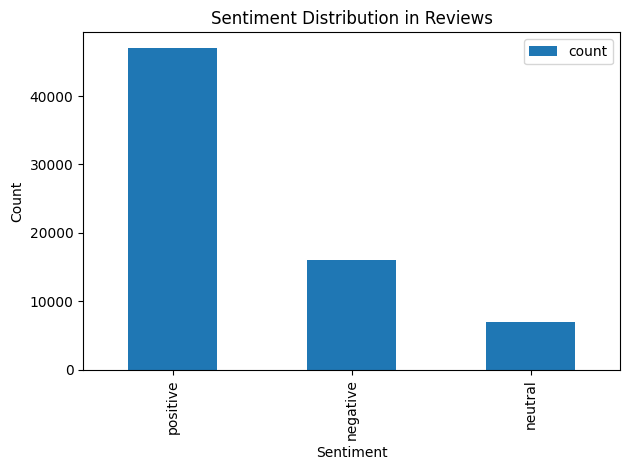

In [ ]:

print("\nSentiment Distribution:")
print(pd.Series(sentiment_counts))

plt.figure(figsize=(10, 6))
sentiment_df = pd.DataFrame.from_dict(sentiment_counts, orient='index', columns=['count'])
sentiment_df.plot(kind='bar')
plt.title('Sentiment Distribution in Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Step 6: Process Business Data

In [ ]:
print("\nProcessing business data...")
business_file = os.path.join(path, "yelp_academic_dataset_business.json")

# Initialize containers for analysis
category_counter = Counter()
state_businesses = {}  # Dynamically store businesses by region (state/province)

# Process businesses in chunks
chunk_count = 0
for chunk in pd.read_json(business_file, lines=True, chunksize=CHUNK_SIZE):
    # Remove rows with missing categories
    chunk = chunk.dropna(subset=['categories'])

    # Update category counts
    chunk_categories = analyze_categories(chunk['categories'])
    category_counter.update(chunk_categories)

    # Store businesses by state/province
    for state in chunk['state'].unique():
        if state not in state_businesses:
            state_businesses[state] = []
        state_businesses[state].append(chunk[chunk['state'] == state][['business_id', 'categories', 'name', 'city', 'state']])

    # Clean up memory
    del chunk
    gc.collect()
    chunk_count += 1
    if chunk_count % 10 == 0:
        print(f"Processed {chunk_count} business chunks...")

# Combine all chunks for each state/province
state_businesses_combined = {}
for state, chunks in state_businesses.items():
    state_businesses_combined[state] = pd.concat(chunks, ignore_index=True)

# List all states/provinces processed
print("\nStates/Provinces in the dataset:")
print(list(state_businesses_combined.keys()))


Processing business data...
Processed 10 business chunks...

States/Provinces in the dataset:
['CA', 'MO', 'AZ', 'PA', 'TN', 'FL', 'IN', 'LA', 'AB', 'NV', 'ID', 'DE', 'IL', 'NJ', 'NC', 'CO', 'WA', 'HI', 'UT', 'TX', 'MT', 'MI', 'SD', 'XMS', 'MA', 'VI', 'VT']



Canadian provinces in the dataset: ['AB']

Investigating 'XMS' region:
              business_id                                         categories  \
0  IvQs2hhXKZ4NgZhVZ5jjjQ  Caterers, Breakfast & Brunch, Convenience Stor...   

                     name       city state  
0  Pumpernickles Catering  Liverpool   XMS  

Businesses by state/province:
PA: 34013
FL: 26309
TN: 12051
IN: 11243
MO: 10907
LA: 9916
AZ: 9906
NJ: 8527
NV: 7706
AB: 5572
CA: 5202
ID: 4464
DE: 2262
IL: 2144
TX: 4
CO: 3
WA: 2
HI: 2
MA: 2
NC: 1
UT: 1
MT: 1
MI: 1
SD: 1
XMS: 1
VI: 1
VT: 1

Valid states/provinces with sufficient data for visualization:
CA: 5202
MO: 10907
AZ: 9906
PA: 34013
TN: 12051
FL: 26309
IN: 11243
LA: 9916
AB: 5572
NV: 7706
ID: 4464
DE: 2262
IL: 2144
NJ: 8527


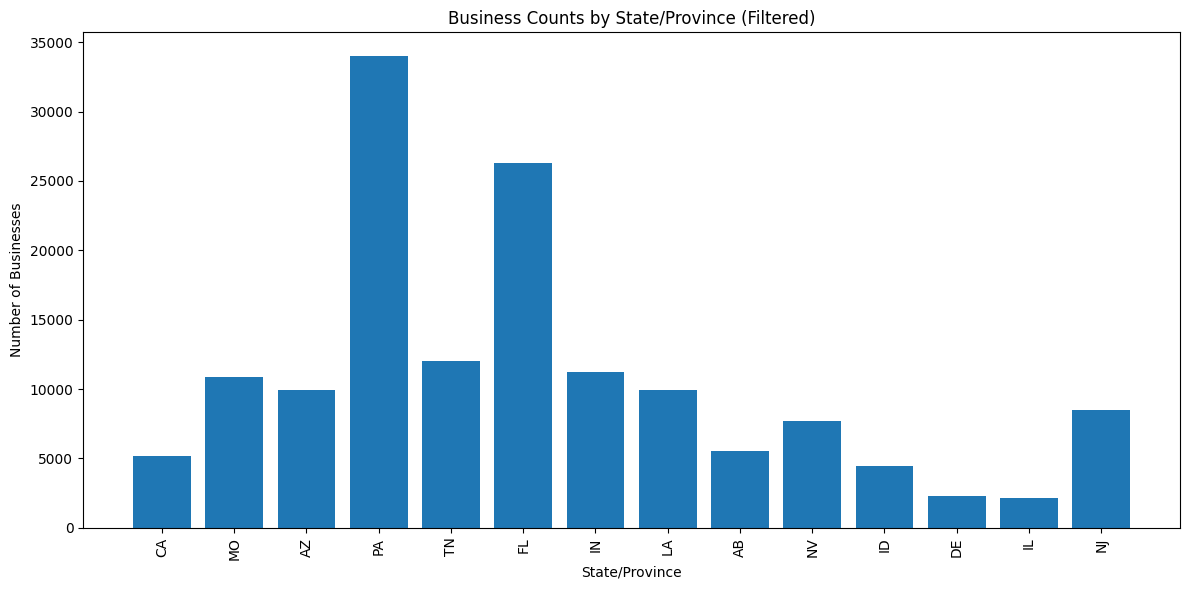

In [ ]:
### Step 7: Verify States/Provinces and Analyze Distribution

# Canadian provinces list
canadian_provinces = ['AB', 'BC', 'MB', 'NB', 'NL', 'NS', 'ON', 'PE', 'QC', 'SK']

# Identify Canadian provinces in the dataset
canadian_in_dataset = [state for state in state_businesses_combined.keys() if state in canadian_provinces]
print("\nCanadian provinces in the dataset:", canadian_in_dataset)

# Investigate unidentified codes (e.g., 'XMS')
if 'XMS' in state_businesses_combined:
    print("\nInvestigating 'XMS' region:")
    xms_data = state_businesses_combined.get('XMS', pd.DataFrame())
    print(xms_data.head())
else:
    print("\nNo unidentified regions found.")

# Count businesses by state/province
business_counts = {state: len(df) for state, df in state_businesses_combined.items()}
print("\nBusinesses by state/province:")
for state, count in sorted(business_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{state}: {count}")

# Filter and visualize only regions with sufficient data
threshold = 10  # Minimum number of businesses to include in visualizations
valid_states = {state: count for state, count in business_counts.items() if count >= threshold}

print("\nValid states/provinces with sufficient data for visualization:")
for state, count in valid_states.items():
    print(f"{state}: {count}")

# Visualize filtered data
plt.figure(figsize=(12, 6))
states = list(valid_states.keys())
counts = list(valid_states.values())
plt.bar(states, counts)
plt.title("Business Counts by State/Province (Filtered)")
plt.xlabel("State/Province")
plt.ylabel("Number of Businesses")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Step 7: Business Category Analysis

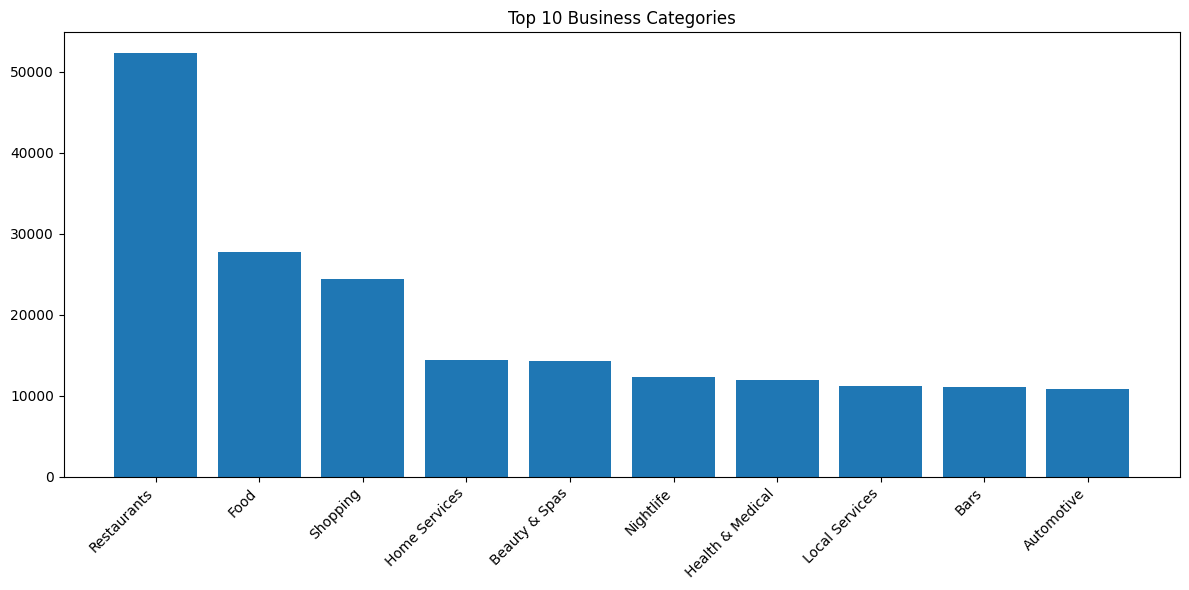

In [ ]:

category_df = pd.DataFrame(category_counter.most_common(), columns=['Category', 'Count'])

plt.figure(figsize=(12, 6))
top_categories = category_df.head(10)
plt.bar(top_categories['Category'], top_categories['Count'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Business Categories')
plt.tight_layout()
plt.show()

### Step 8: Regional Analysis


Regional category summary (all regions):

Top categories for CA:
           Category  Count
0       Restaurants   1161
1          Shopping    936
2              Food    835
3     Home Services    638
4  Health & Medical    592

Top categories for MO:
      Category  Count
0  Restaurants   4247
1         Food   2023
2     Shopping   1823
3    Nightlife   1202
4         Bars   1092

Top categories for AZ:
           Category  Count
0       Restaurants   2671
1          Shopping   1780
2              Food   1520
3     Home Services   1390
4  Health & Medical   1032

Top categories for PA:
        Category  Count
0    Restaurants  12641
1           Food   6637
2       Shopping   5308
3  Beauty & Spas   3399
4  Home Services   3032

Top categories for TN:
        Category  Count
0    Restaurants   4352
1           Food   2194
2       Shopping   1894
3      Nightlife   1146
4  Beauty & Spas   1131

Top categories for FL:
        Category  Count
0    Restaurants   8731
1           Food   478

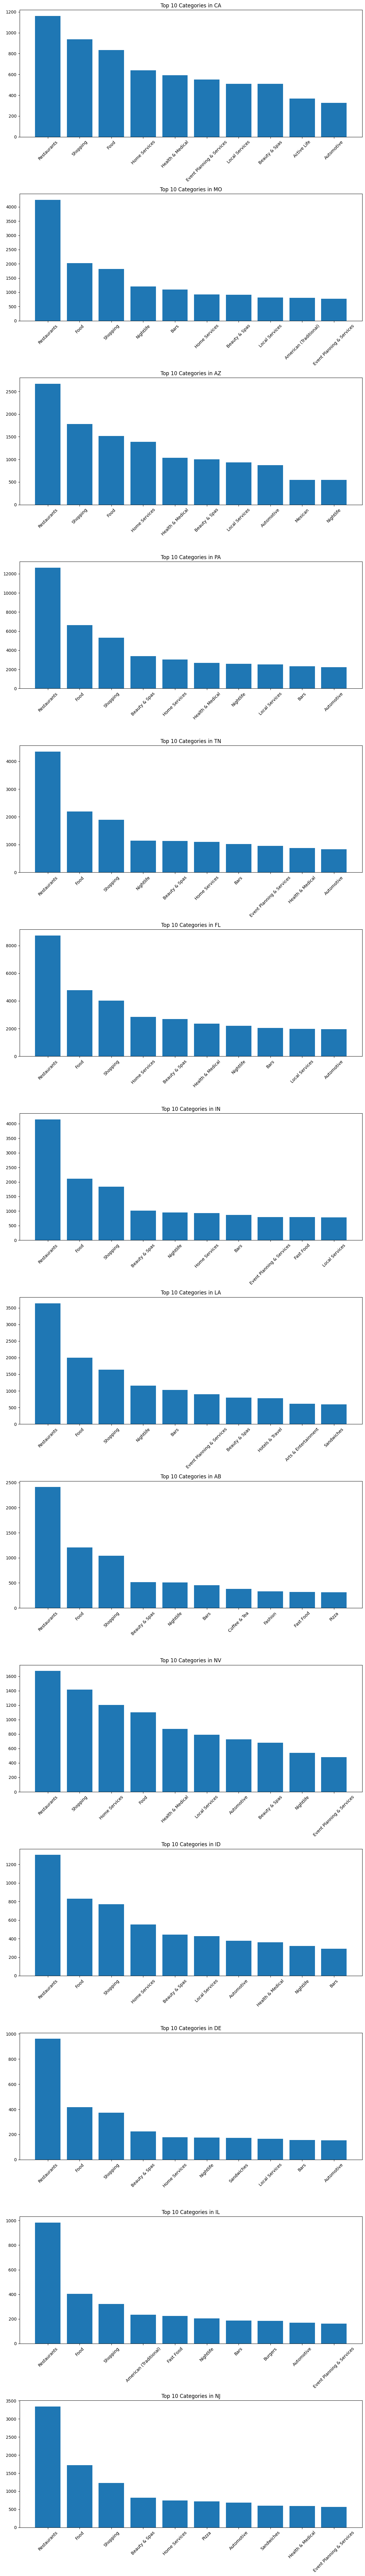

In [ ]:
# Prepare regional category analysis (all regions, including sparse ones)
regional_categories = {}
for state, chunks in state_businesses.items():
    if chunks:
        # Combine chunks for the state
        regional_df = pd.concat(chunks, ignore_index=True)
        # Analyze categories
        regional_counter = analyze_categories(regional_df['categories'])
        regional_categories[state] = pd.DataFrame(regional_counter.most_common(),
                                                  columns=['Category', 'Count'])

# Display summary for all regions
print("\nRegional category summary (all regions):")
for state, category_df in regional_categories.items():
    print(f"\nTop categories for {state}:")
    print(category_df.head())

# Visualization: Filter for valid regions (those with sufficient data)
filtered_regional_categories = {state: regional_categories[state] for state in valid_states}

if filtered_regional_categories:
    print("\nVisualizing regional category trends for valid regions...")

    fig, axes = plt.subplots(len(filtered_regional_categories), 1, figsize=(12, 6 * len(filtered_regional_categories)))

    # Ensure axes is iterable for single-region cases
    if len(filtered_regional_categories) == 1:
        axes = [axes]

    for ax, (region, data) in zip(axes, filtered_regional_categories.items()):
        # Plot top 10 categories for the region
        top_regional = data.head(10)
        ax.bar(top_regional['Category'], top_regional['Count'])
        ax.set_title(f'Top 10 Categories in {region}')
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()
else:
    print("No valid regions with sufficient data for visualization.")

In [ ]:
# Explore available categories in the dataset
print("Exploring available categories...")

# Initialize a Counter for all categories
all_categories = Counter()

# Process business data in chunks to collect category information
for chunk in pd.read_json(business_json_path, lines=True, chunksize=CHUNK_SIZE):
    chunk = chunk.dropna(subset=['categories'])  # Drop rows with missing categories
    categories_series = chunk['categories'].str.split(', ')
    for categories in categories_series:
        if isinstance(categories, list):
            all_categories.update(categories)

    del chunk  # Free memory
    gc.collect()

# Display the top 30 categories
print("\nTop 30 categories in the dataset:")
print(all_categories.most_common(20))

Exploring available categories...

Top 30 categories in the dataset:
[('Restaurants', 52268), ('Food', 27781), ('Shopping', 24395), ('Home Services', 14356), ('Beauty & Spas', 14292), ('Nightlife', 12281), ('Health & Medical', 11890), ('Local Services', 11198), ('Bars', 11065), ('Automotive', 10773), ('Event Planning & Services', 9895), ('Sandwiches', 8366), ('American (Traditional)', 8139), ('Active Life', 7687), ('Pizza', 7093), ('Coffee & Tea', 6703), ('Fast Food', 6472), ('Breakfast & Brunch', 6239), ('American (New)', 6097), ('Hotels & Travel', 5857)]


**Step 9: Filter and Process Businesses by Categories**

In [ ]:
# Ensure paths are defined
business_json_path = os.path.join(path, 'yelp_academic_dataset_business.json')
review_json_path = os.path.join(path, 'yelp_academic_dataset_review.json')

# Ensure CHUNK_SIZE is defined
CHUNK_SIZE = 10000  # Adjust as necessary for available memory

# Categories of interest
target_categories = ['Pizza', 'Breakfast & Brunch', 'Specialty Food']

# Initialize filtered businesses for each category
filtered_businesses = {category: [] for category in target_categories}

# Process businesses in chunks to match categories
print("\nFiltering businesses by categories...")
for chunk in pd.read_json(business_json_path, lines=True, chunksize=CHUNK_SIZE):
    for category in target_categories:
        filtered_chunk = chunk[chunk['categories'].str.contains(category, case=False, na=False)]
        filtered_businesses[category].append(filtered_chunk)
    del chunk
    gc.collect()

# Combine filtered chunks for each category
filtered_businesses = {cat: pd.concat(chunks, ignore_index=True) for cat, chunks in filtered_businesses.items()}

# Separate businesses by USA and Canada
usa_states = [state for state in business_counts if state not in canadian_provinces]
canada_states = [state for state in business_counts if state in canadian_provinces]

usa_businesses = {cat: df[df['state'].isin(usa_states)] for cat, df in filtered_businesses.items()}
canada_businesses = {cat: df[df['state'].isin(canada_states)] for cat, df in filtered_businesses.items()}

# Helper function to process reviews by category in chunks
def process_category_reviews(category_name, businesses, review_path):
    """Merge businesses with reviews and analyze sentiment in chunks."""
    category_reviews = []
    sentiment_counts = Counter()

    # Process reviews in chunks
    for review_chunk in pd.read_json(review_path, lines=True, chunksize=CHUNK_SIZE):
        merged_chunk = review_chunk.merge(
            businesses[['business_id', 'state', 'categories']],
            on='business_id',
            how='inner'
        )
        # Add sentiment
        merged_chunk['sentiment'] = merged_chunk['stars'].apply(assign_sentiment)

        # Aggregate sentiment counts
        sentiment_counts.update(
            merged_chunk.groupby(['state', 'sentiment']).size().to_dict()
        )

        # Collect processed reviews
        category_reviews.append(merged_chunk)
        del review_chunk, merged_chunk
        gc.collect()

    # Combine all processed reviews
    category_reviews_df = pd.concat(category_reviews, ignore_index=True)

    # Convert sentiment counts into a properly structured DataFrame
    sentiment_counts_df = pd.DataFrame(
        [(state, sentiment, count) for (state, sentiment), count in sentiment_counts.items()],
        columns=['state', 'sentiment', 'count']
    )

    return category_reviews_df, sentiment_counts_df

# Process reviews for each category
category_sentiments = {}
for category, business_df in filtered_businesses.items():
    print(f"\nProcessing sentiment analysis for {category}...")
    category_reviews, sentiment_counts = process_category_reviews(category, business_df, review_json_path)
    category_sentiments[category] = {
        'reviews': category_reviews,
        'sentiments': sentiment_counts
    }

# Display sentiment summaries for USA and Canada
for category, data in category_sentiments.items():
    print(f"\nSentiment distribution for {category}:")
    print(data['sentiments'])


Filtering businesses by categories...

Processing sentiment analysis for Pizza...

Processing sentiment analysis for Breakfast & Brunch...

Processing sentiment analysis for Specialty Food...

Sentiment distribution for Pizza:
   state sentiment  count
0     AB  negative   1574
1     AB  positive   4266
2     AZ  negative   6809
3     AZ   neutral   3329
4     AZ  positive  19031
5     CA  negative   3282
6     CA   neutral   1498
7     CA  positive  10869
8     DE  negative   1769
9     DE   neutral    693
10    DE  positive   3448
11    FL  negative  17169
12    FL   neutral   7192
13    FL  positive  53041
14    ID  negative   2189
15    ID   neutral    957
16    ID  positive   6168
17    IL  positive   2749
18    IN  negative   8347
19    IN   neutral   4300
20    IN  positive  23847
21    LA  negative   5467
22    LA   neutral   2864
23    LA  positive  16973
24    MO  negative   8784
25    MO   neutral   4435
26    MO  positive  26260
27    NJ  negative   7538
28    NJ   neutral

**Step 10: Visualize Sentiment Analysis Results**

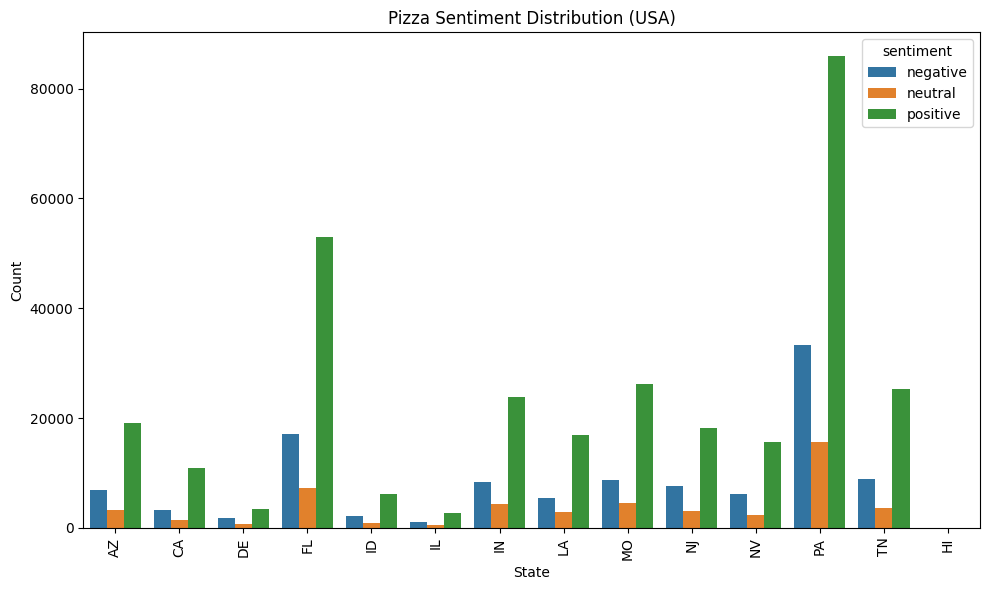

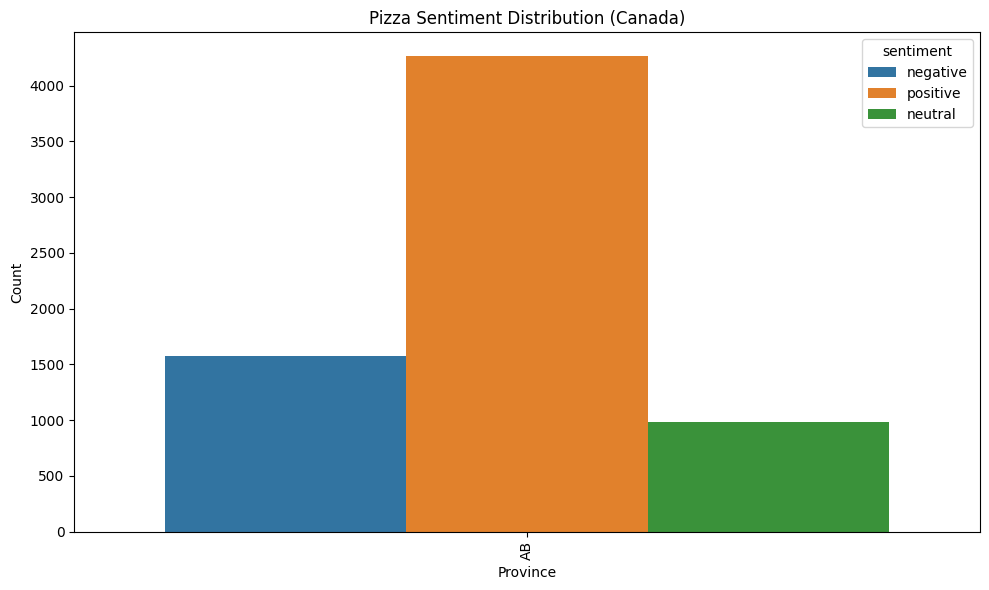

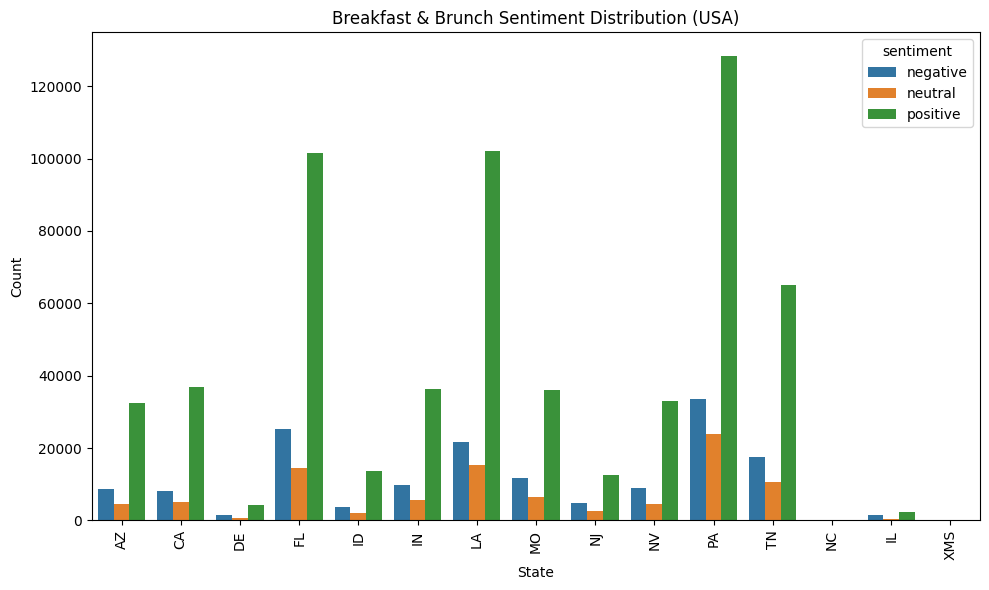

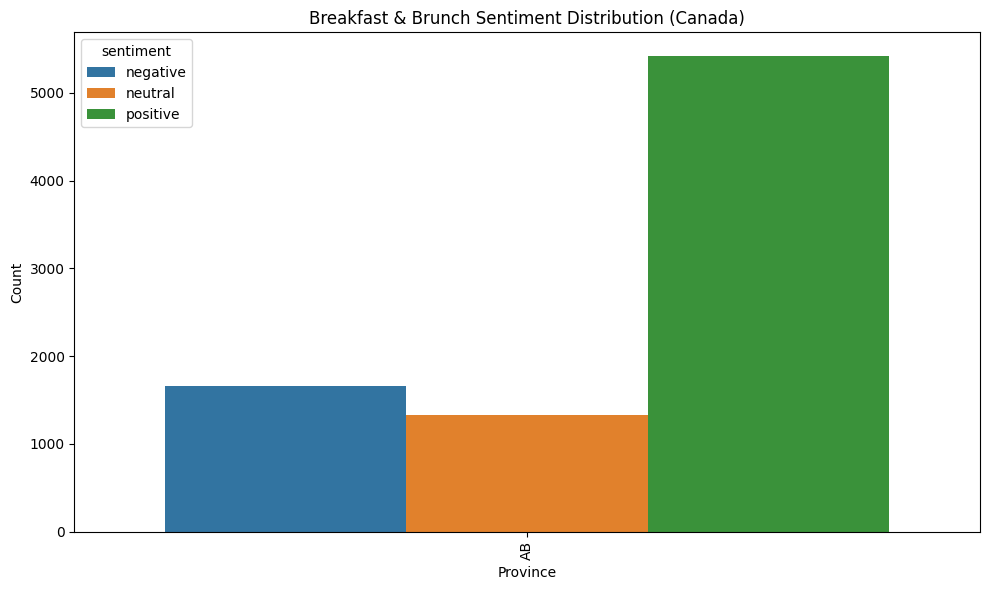

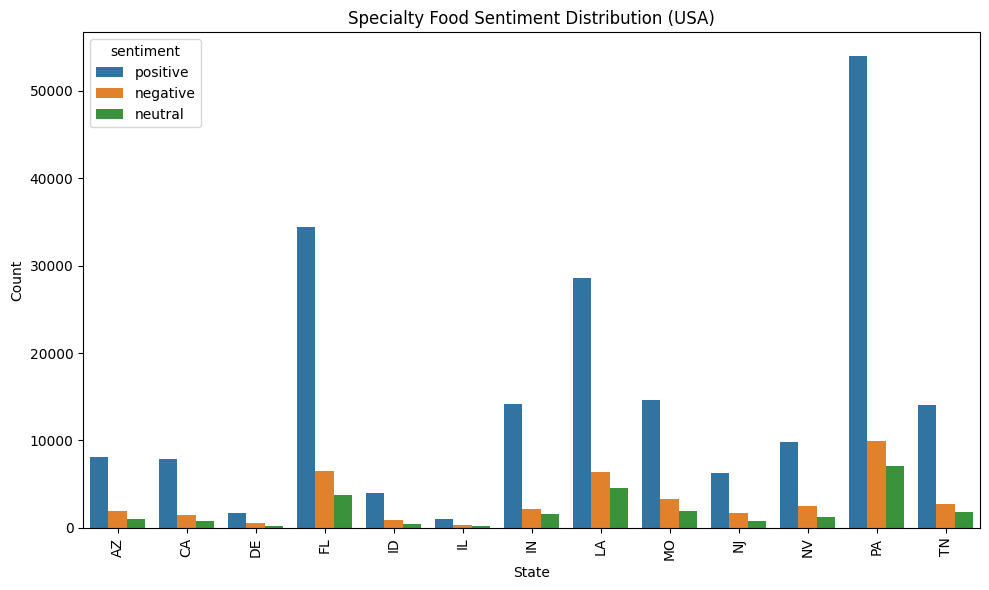

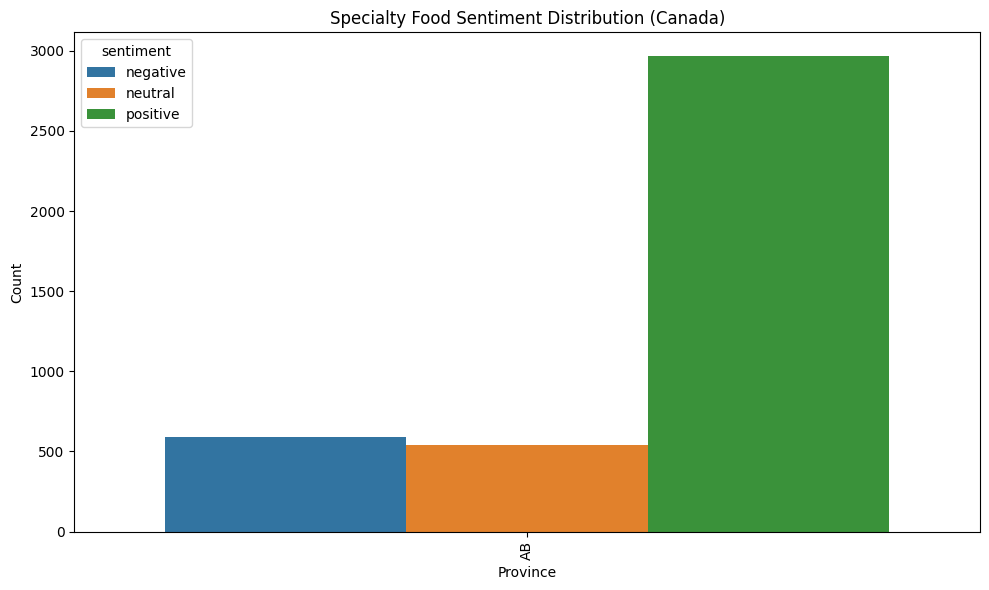

In [ ]:


for category, data in category_sentiments.items():
    sentiment_counts = data['sentiments']

    # USA Sentiment Visualization
    usa_sentiments = sentiment_counts[sentiment_counts['state'].isin(usa_states)]
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='state', y='count', hue='sentiment', data=usa_sentiments,
        order=usa_sentiments['state'].unique()
    )
    plt.title(f"{category} Sentiment Distribution (USA)")
    plt.xlabel("State")
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # Canada Sentiment Visualization
    canada_sentiments = sentiment_counts[sentiment_counts['state'].isin(canada_states)]
    if not canada_sentiments.empty:
        plt.figure(figsize=(10, 6))
        sns.barplot(
            x='state', y='count', hue='sentiment', data=canada_sentiments,
            order=canada_sentiments['state'].unique()
        )
        plt.title(f"{category} Sentiment Distribution (Canada)")
        plt.xlabel("Province")
        plt.ylabel("Count")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No sentiment data for {category} in Canada.")

**Step 11: Apply VADER Sentiment Analysis to Review Text**

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER model if not already available
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Helper function to calculate VADER sentiment scores
def calculate_vader_sentiment(review_text):
    """Apply VADER sentiment analysis to a review."""
    scores = sia.polarity_scores(review_text)
    return scores['compound']  # Use compound score for overall sentiment

# Apply VADER sentiment analysis to reviews for each category
for category, data in category_sentiments.items():
    print(f"Applying VADER sentiment analysis to {category} reviews...")
    reviews = data['reviews']
    reviews['vader_sentiment'] = reviews['text'].apply(calculate_vader_sentiment)
    print(f"VADER sentiment analysis completed for {category}.")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Applying VADER sentiment analysis to Pizza reviews...
VADER sentiment analysis completed for Pizza.
Applying VADER sentiment analysis to Breakfast & Brunch reviews...
VADER sentiment analysis completed for Breakfast & Brunch.
Applying VADER sentiment analysis to Specialty Food reviews...
VADER sentiment analysis completed for Specialty Food.


In [ ]:
### Filter for valid states (regions with sufficient data)

# Define a threshold for valid regions (e.g., at least 5 reviews)
MIN_REVIEWS = 5

valid_states = {}
for category, data in category_sentiments.items():
    reviews = data['reviews']
    state_counts = reviews['state'].value_counts()
    valid_states[category] = state_counts[state_counts >= MIN_REVIEWS].index.tolist()

    print(f"Valid states for {category}: {valid_states[category]}")

Valid states for Pizza: ['PA', 'FL', 'MO', 'TN', 'IN', 'AZ', 'NJ', 'LA', 'NV', 'CA', 'ID', 'AB', 'DE', 'IL', 'HI']
Valid states for Breakfast & Brunch: ['PA', 'FL', 'LA', 'TN', 'MO', 'IN', 'CA', 'NV', 'AZ', 'NJ', 'ID', 'AB', 'DE', 'IL', 'NC', 'XMS']
Valid states for Specialty Food: ['PA', 'FL', 'LA', 'MO', 'TN', 'IN', 'NV', 'AZ', 'CA', 'NJ', 'ID', 'AB', 'DE', 'IL']


**Step 12: Compare Sentiment Trends Across Clusters (Excluding Sparse Regions)**

Sentiment trends by cluster for Pizza saved to sentiment_by_cluster_Pizza.csv.


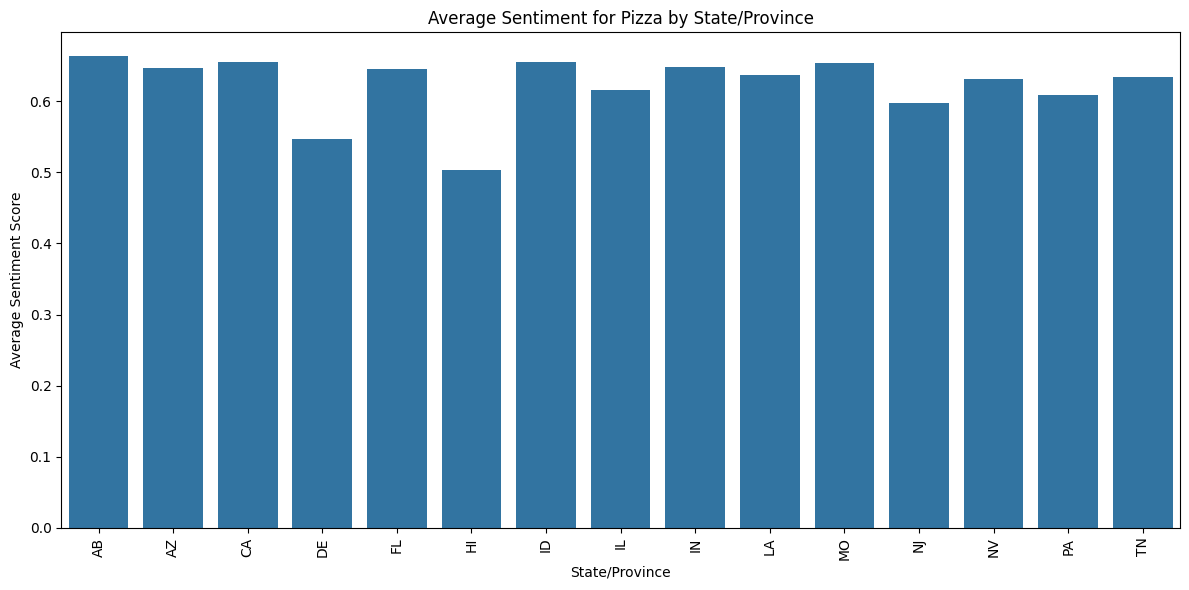

Sentiment trends by cluster for Breakfast & Brunch saved to sentiment_by_cluster_Breakfast & Brunch.csv.


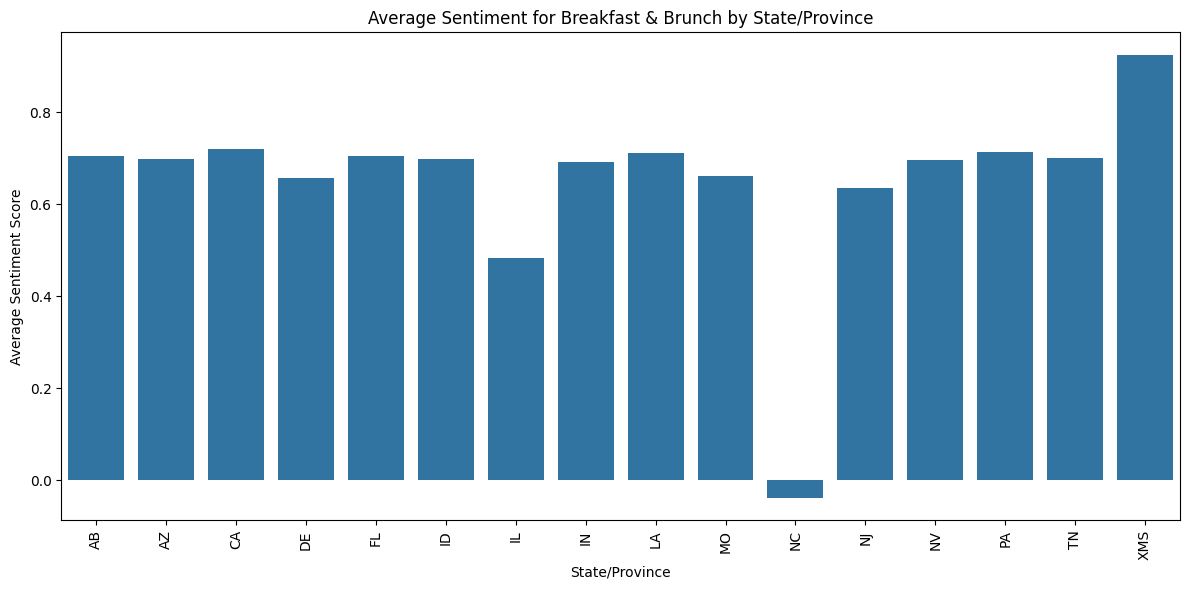

Sentiment trends by cluster for Specialty Food saved to sentiment_by_cluster_Specialty Food.csv.


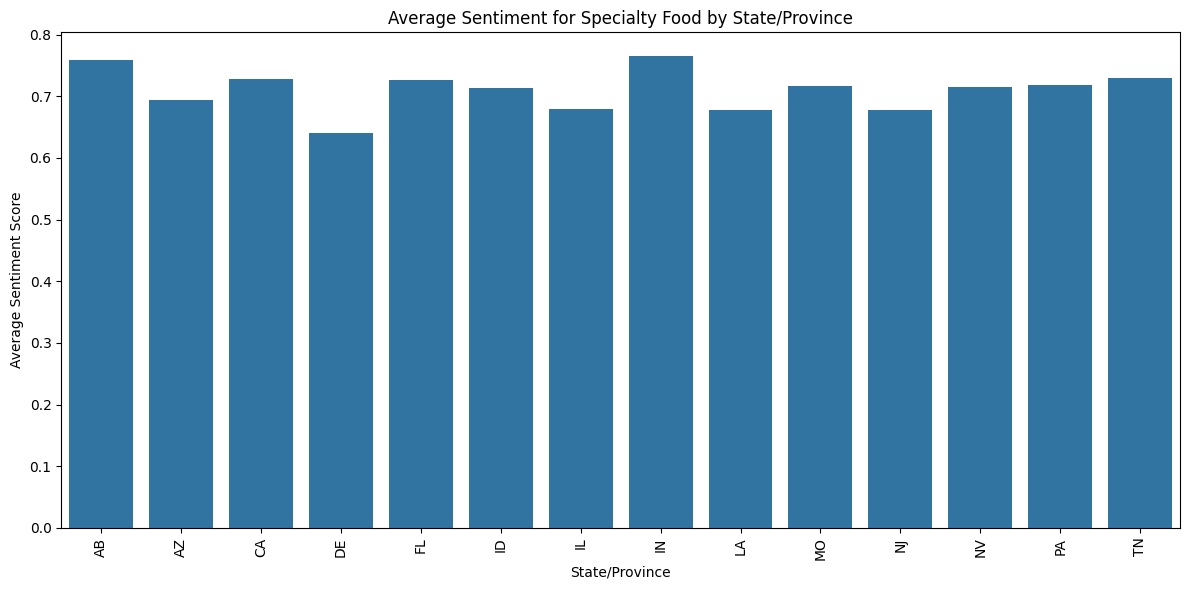

In [ ]:


for category, data in category_sentiments.items():
    reviews = data['reviews']

    # Filter for valid states
    reviews = reviews[reviews['state'].isin(valid_states[category])]

    # Aggregate sentiment scores by state/province
    sentiment_by_cluster = reviews.groupby('state')['vader_sentiment'].mean().reset_index()
    sentiment_by_cluster.columns = ['state', 'avg_sentiment']

    # Save sentiment trends by cluster
    output_file = f"sentiment_by_cluster_{category}.csv"
    sentiment_by_cluster.to_csv(output_file, index=False)
    print(f"Sentiment trends by cluster for {category} saved to {output_file}.")

    # Visualize sentiment trends
    plt.figure(figsize=(12, 6))
    sns.barplot(x='state', y='avg_sentiment', data=sentiment_by_cluster)
    plt.title(f"Average Sentiment for {category} by State/Province")
    plt.xlabel("State/Province")
    plt.ylabel("Average Sentiment Score")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

**Step 13: Correlation Between Sentiment and Ratings (with Filtering)**

In [ ]:


for category, data in category_sentiments.items():
    reviews = data['reviews']

    # Filter reviews for valid states
    reviews = reviews[reviews['state'].isin(valid_states[category])]

    # Compute correlation
    correlation = np.corrcoef(reviews['vader_sentiment'], reviews['stars'])[0, 1]
    print(f"Correlation between sentiment and ratings for {category}: {correlation:.2f}")

Correlation between sentiment and ratings for Pizza: 0.66
Correlation between sentiment and ratings for Breakfast & Brunch: 0.63
Correlation between sentiment and ratings for Specialty Food: 0.60


**Step 14: Analyze High and Low-Performing Businesses (with Filtering)**


High-performing businesses in Pizza: 203007 reviews.
Low-performing businesses in Pizza: 112472 reviews.


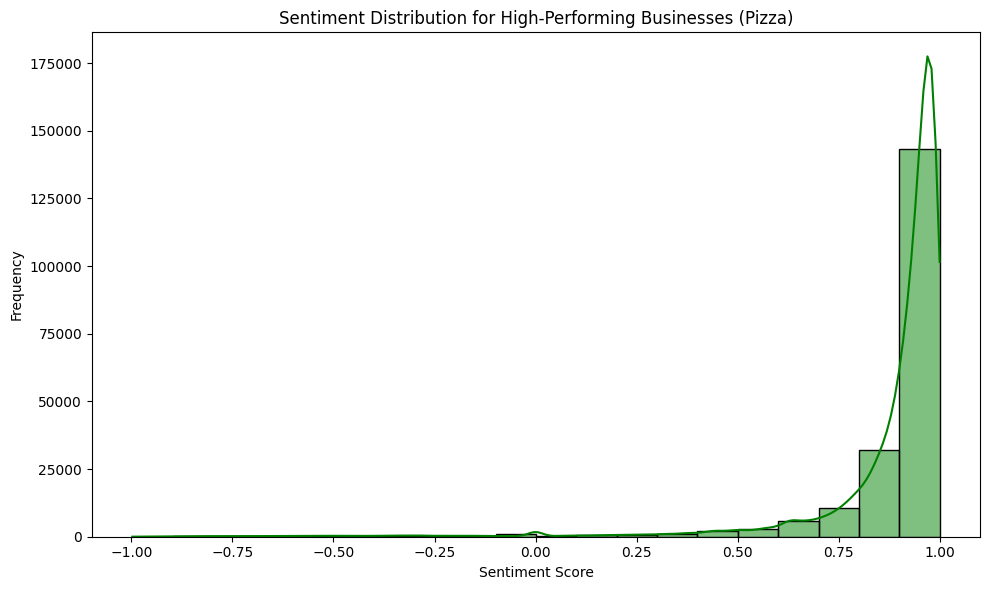

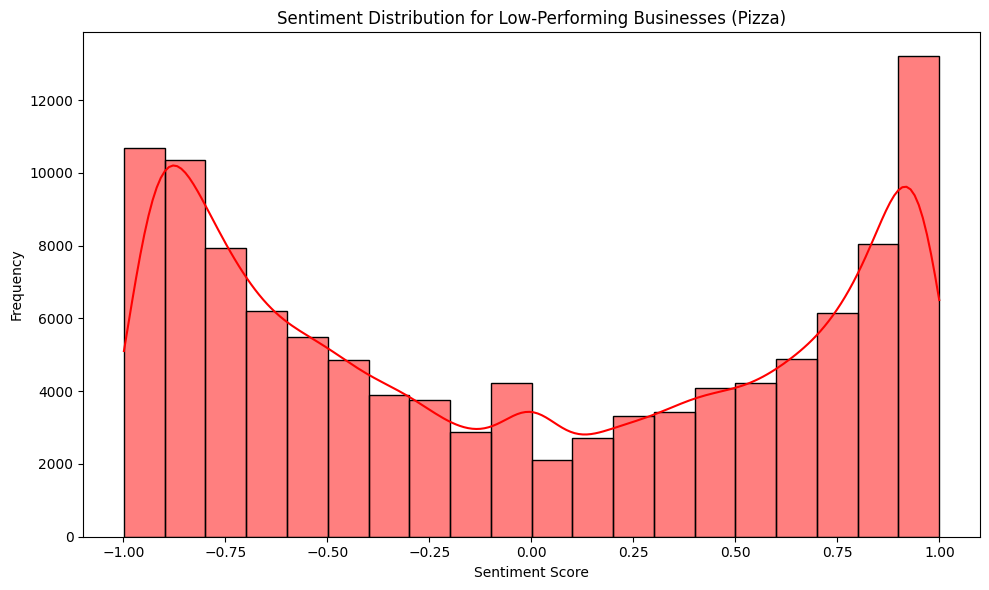


High-performing businesses in Breakfast & Brunch: 400199 reviews.
Low-performing businesses in Breakfast & Brunch: 158680 reviews.


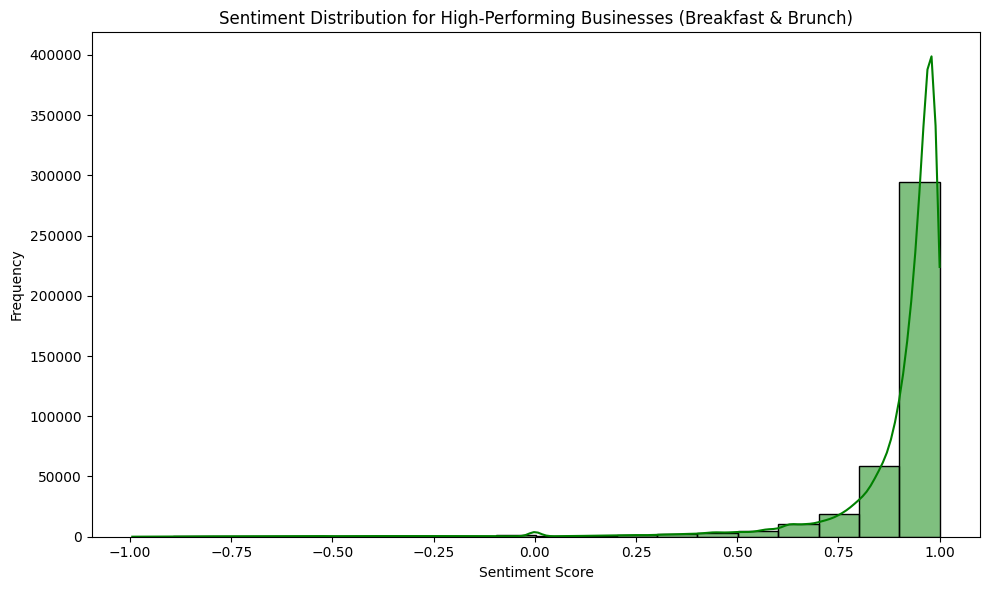

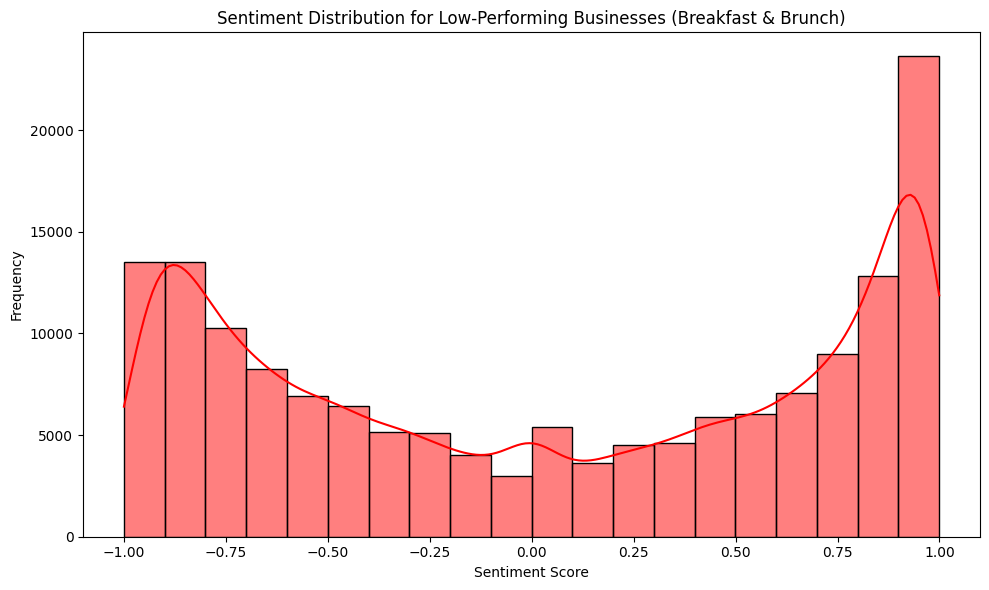


High-performing businesses in Specialty Food: 137643 reviews.
Low-performing businesses in Specialty Food: 40730 reviews.


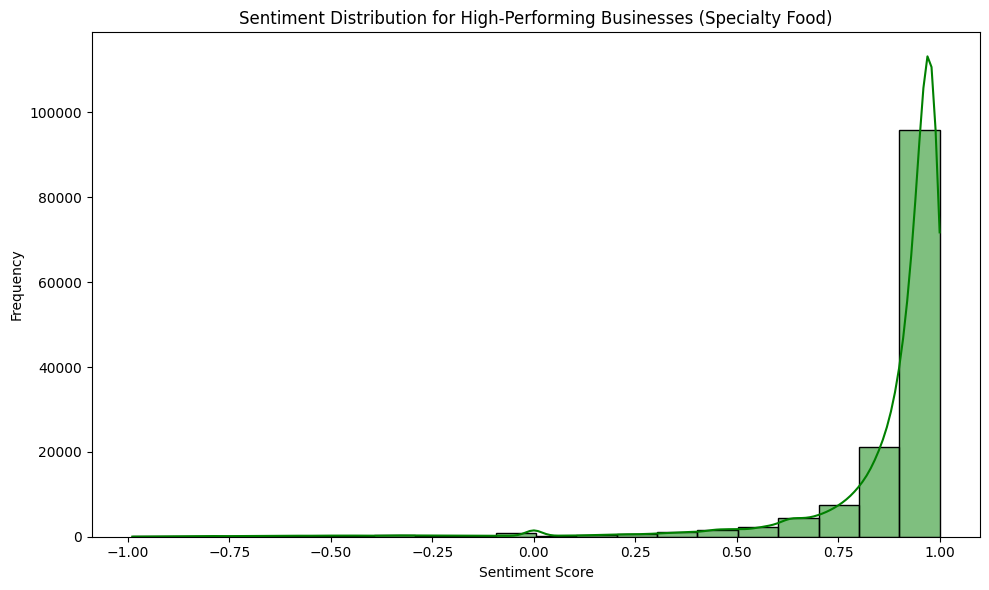

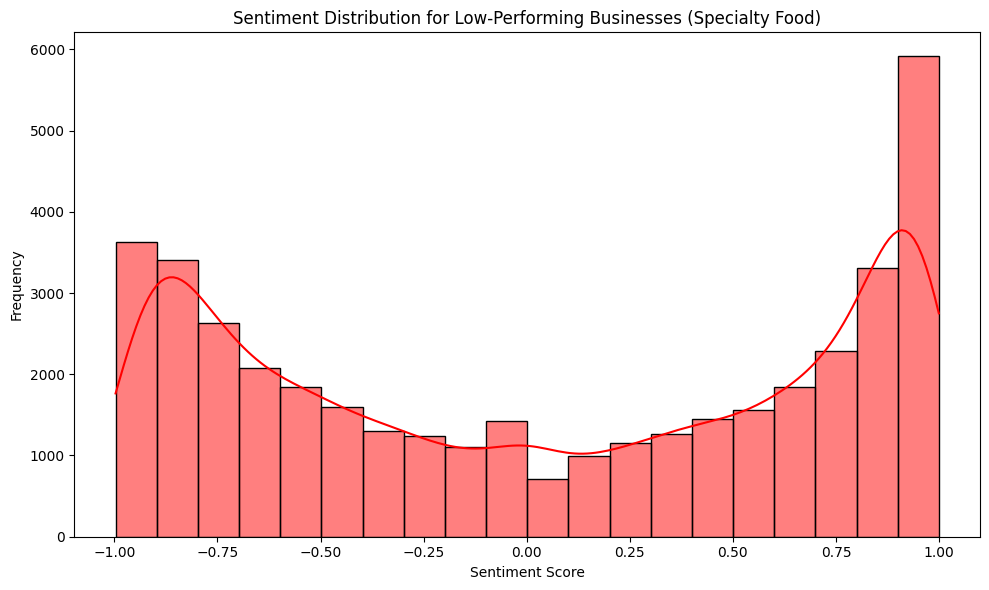

In [ ]:
# Define thresholds for high and low-performing businesses
high_threshold = 4.5
low_threshold = 2.5

for category, data in category_sentiments.items():
    reviews = data['reviews']

    # Filter reviews for valid states
    reviews = reviews[reviews['state'].isin(valid_states[category])]

    # Separate high and low-performing businesses
    high_performers = reviews[reviews['stars'] >= high_threshold]
    low_performers = reviews[reviews['stars'] <= low_threshold]

    print(f"\nHigh-performing businesses in {category}: {len(high_performers)} reviews.")
    print(f"Low-performing businesses in {category}: {len(low_performers)} reviews.")

    # Visualize sentiment for high performers
    plt.figure(figsize=(10, 6))
    sns.histplot(high_performers['vader_sentiment'], bins=20, kde=True, color='green')
    plt.title(f"Sentiment Distribution for High-Performing Businesses ({category})")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Visualize sentiment for low performers
    plt.figure(figsize=(10, 6))
    sns.histplot(low_performers['vader_sentiment'], bins=20, kde=True, color='red')
    plt.title(f"Sentiment Distribution for Low-Performing Businesses ({category})")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

**Step 15: Save Processed Results**

In [ ]:
import os

output_dir = "processed_sentiment_results"
os.makedirs(output_dir, exist_ok=True)

# Save reviews with sentiment scores for each category
for category, data in category_sentiments.items():
    output_file = os.path.join(output_dir, f"{category}_reviews_with_sentiments.csv")
    data['reviews'].to_csv(output_file, index=False)
    print(f"Processed reviews with sentiment scores for {category} saved to {output_file}.")

**Step 16: Sentiment Distribution by State/Province**

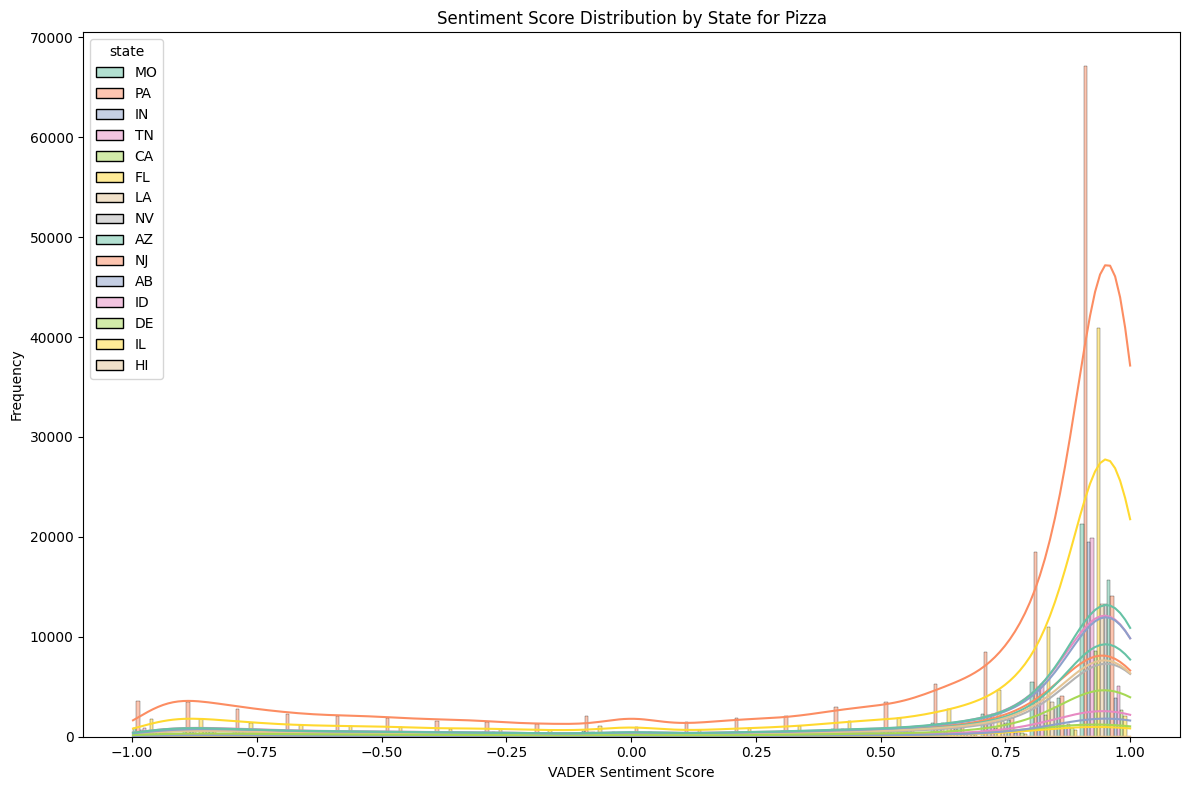

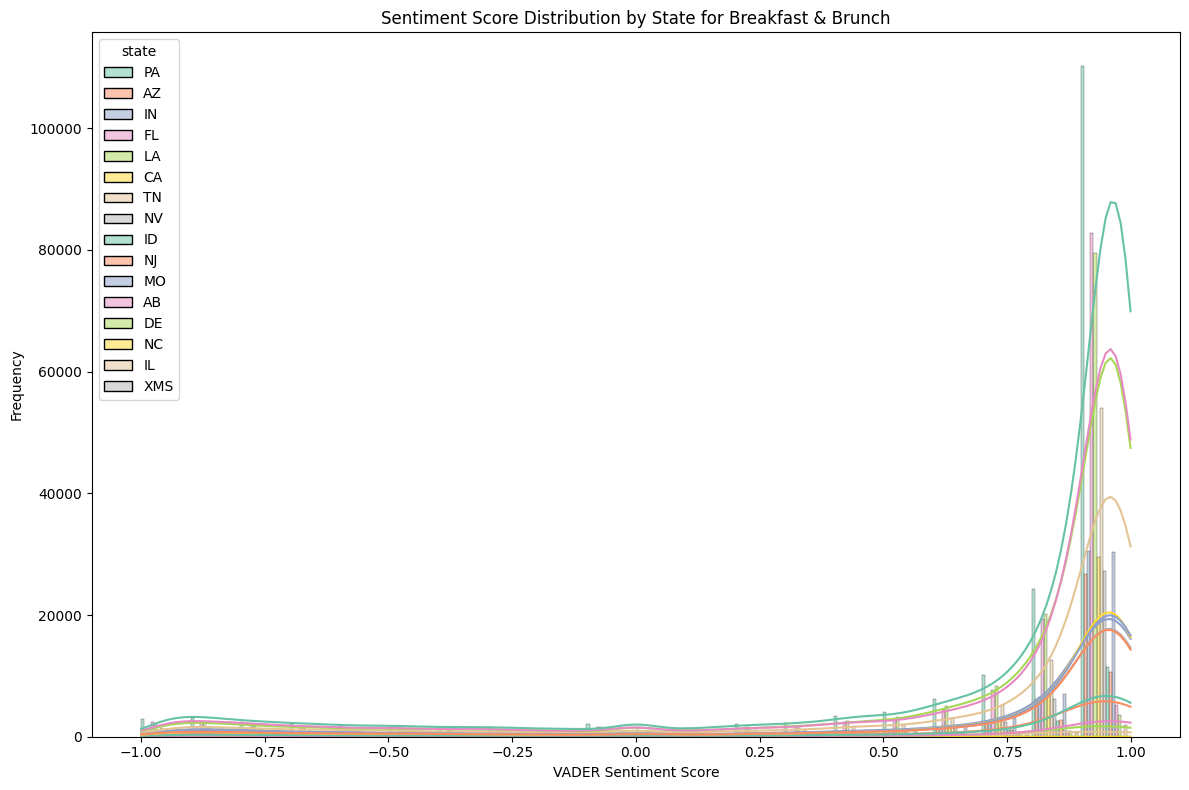

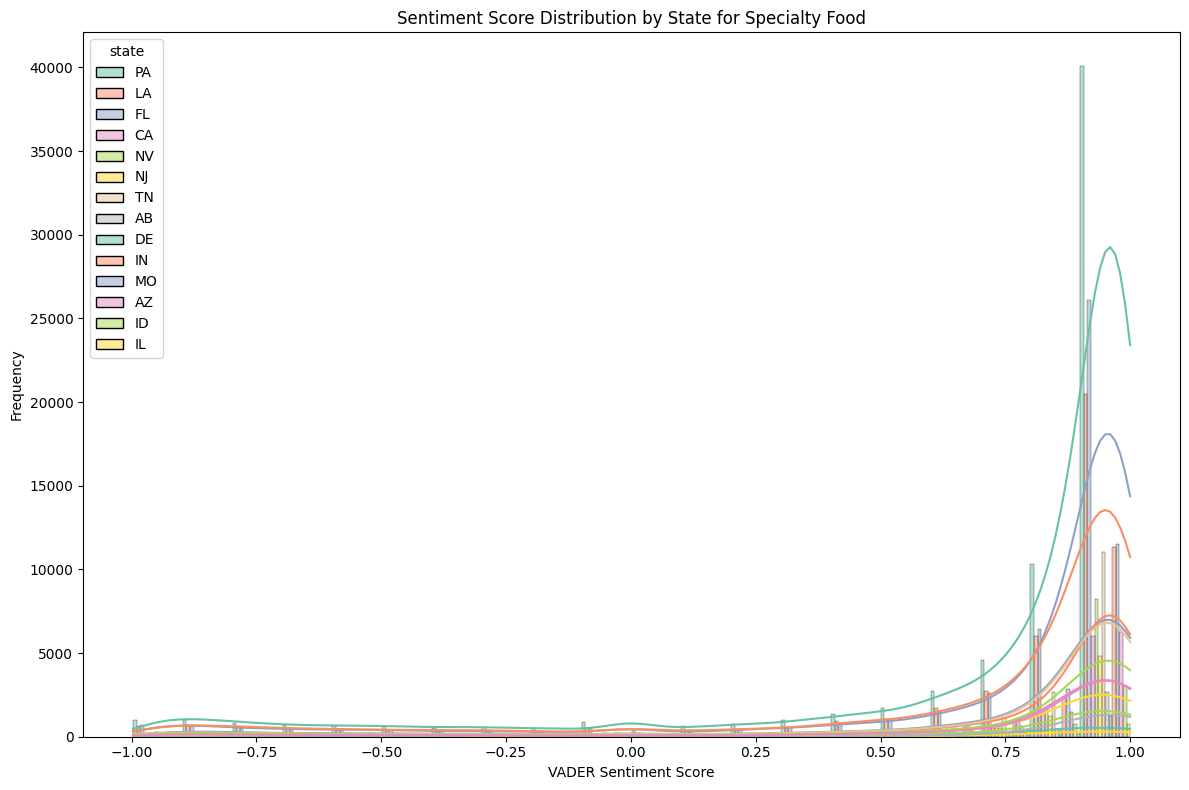

In [ ]:
for category, data in category_sentiments.items():
    reviews = data['reviews']

    # Filter for valid states
    reviews = reviews[reviews['state'].isin(valid_states[category])]

    # Plot sentiment distribution by state
    plt.figure(figsize=(12, 8))
    sns.histplot(data=reviews, x='vader_sentiment', hue='state', bins=20, kde=True, palette='Set2', multiple="dodge")
    plt.title(f"Sentiment Score Distribution by State for {category}")
    plt.xlabel("VADER Sentiment Score")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

**Step 17: Sentiment Distribution for High and Low Performers**

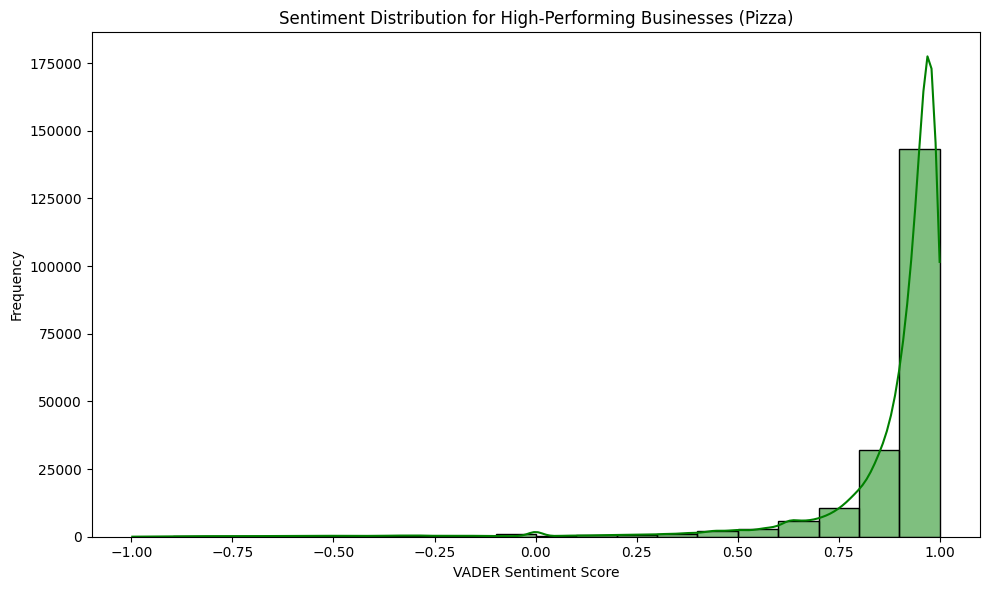

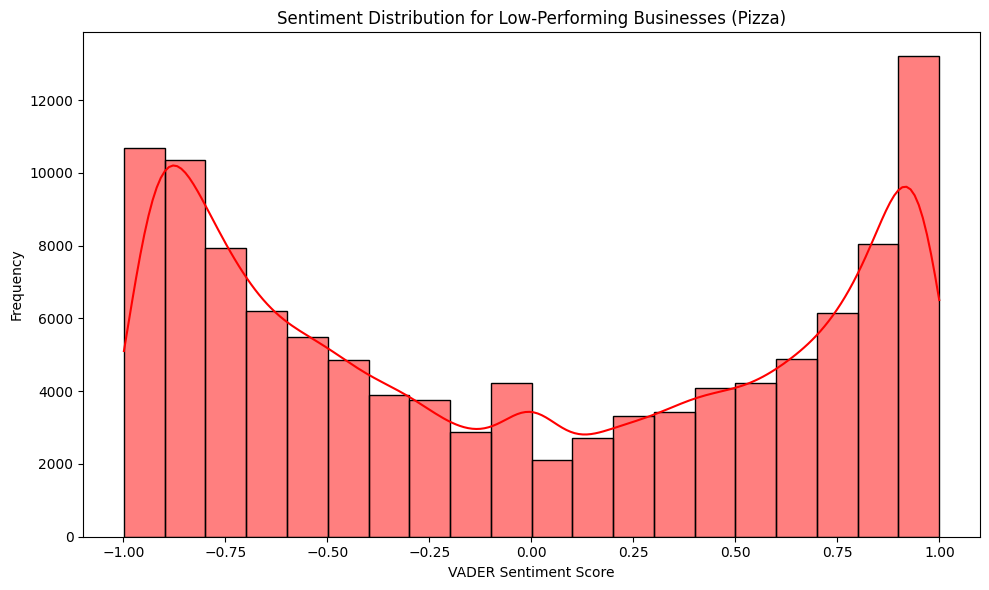

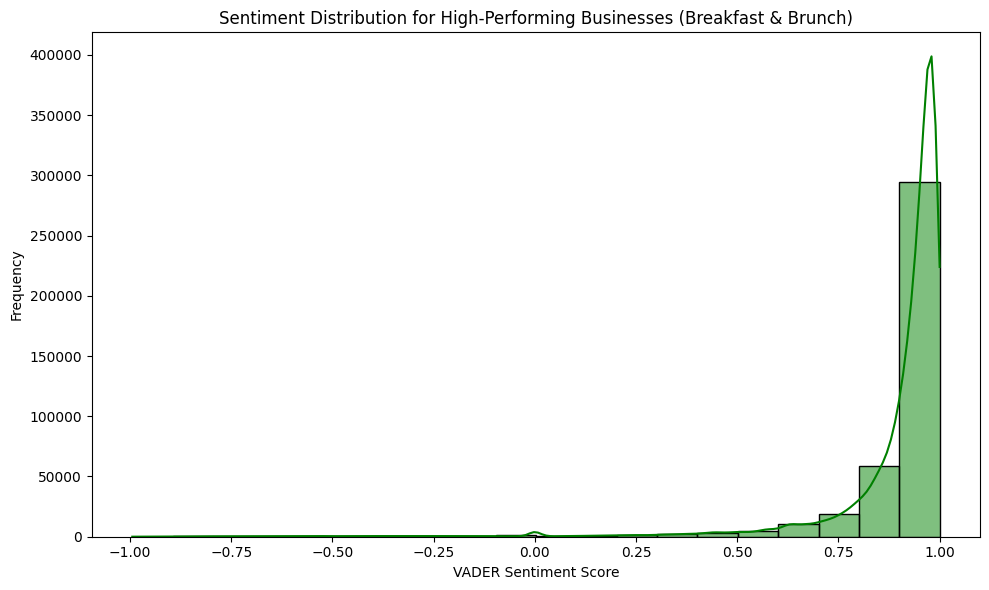

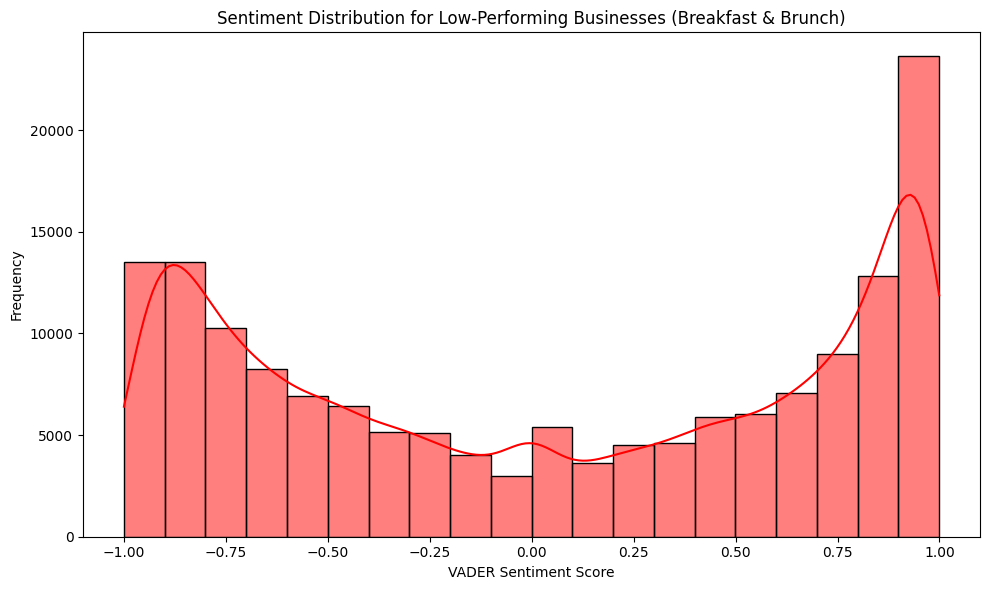

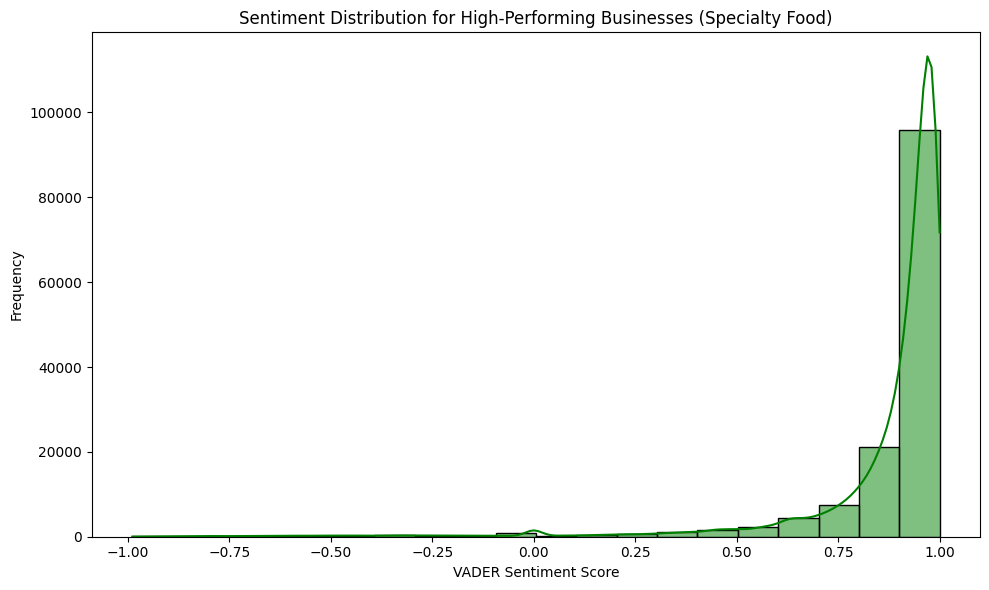

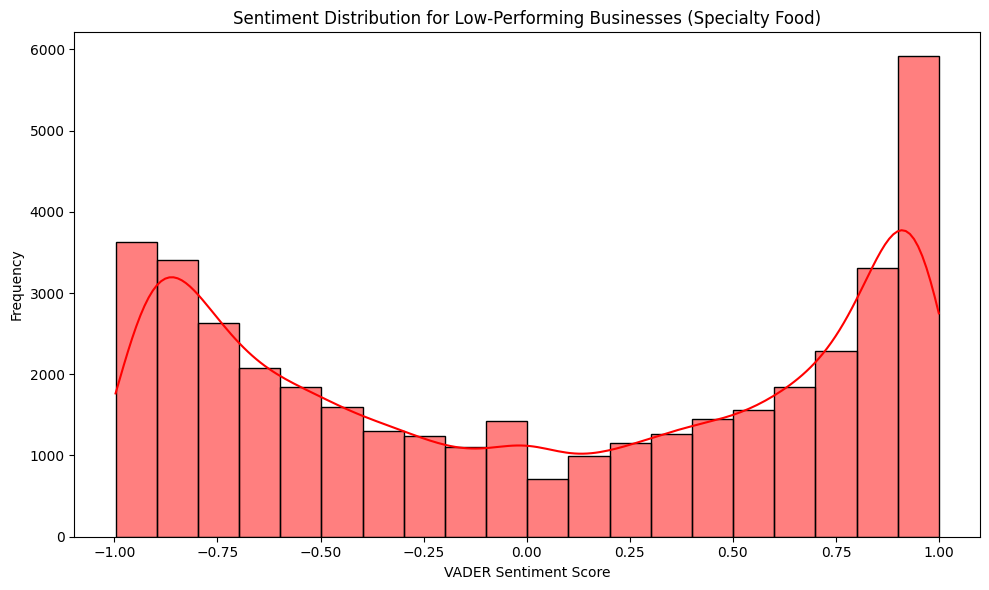

In [ ]:
# Define thresholds
high_threshold = 4.5
low_threshold = 2.5

for category, data in category_sentiments.items():
    reviews = data['reviews']

    # Filter for valid states
    reviews = reviews[reviews['state'].isin(valid_states[category])]

    # Separate high and low performers
    high_performers = reviews[reviews['stars'] >= high_threshold]
    low_performers = reviews[reviews['stars'] <= low_threshold]

    # Plot sentiment for high performers
    plt.figure(figsize=(10, 6))
    sns.histplot(high_performers['vader_sentiment'], bins=20, kde=True, color='green')
    plt.title(f"Sentiment Distribution for High-Performing Businesses ({category})")
    plt.xlabel("VADER Sentiment Score")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Plot sentiment for low performers
    plt.figure(figsize=(10, 6))
    sns.histplot(low_performers['vader_sentiment'], bins=20, kde=True, color='red')
    plt.title(f"Sentiment Distribution for Low-Performing Businesses ({category})")
    plt.xlabel("VADER Sentiment Score")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

**Step 18: Save Results**

In [ ]:
import os

# Create output directory
output_dir = "final_results"
os.makedirs(output_dir, exist_ok=True)

# 1. Save processed reviews with sentiment scores
print("Saving processed reviews with sentiment scores...")
for category, data in category_sentiments.items():
    reviews_file = os.path.join(output_dir, f"{category}_reviews_with_sentiments.csv")
    data['reviews'].to_csv(reviews_file, index=False)
    print(f"Processed reviews for {category} saved to {reviews_file}.")

# 2. Save business category analysis
print("Saving business category analysis...")
business_category_file = os.path.join(output_dir, "business_category_analysis.csv")
category_df.to_csv(business_category_file, index=False)
print(f"Business category analysis saved to {business_category_file}.")

# 3. Save sentiment trends by state/province
print("Saving sentiment trends by region...")
for category, data in category_sentiments.items():
    sentiment_trends_file = os.path.join(output_dir, f"sentiment_by_cluster_{category}.csv")
    sentiment_by_cluster = data['reviews'].groupby('state')['vader_sentiment'].mean().reset_index()
    sentiment_by_cluster.columns = ['state', 'avg_sentiment']
    sentiment_by_cluster.to_csv(sentiment_trends_file, index=False)
    print(f"Sentiment trends for {category} saved to {sentiment_trends_file}.")

# 4. Save high and low performer reviews
print("Saving high and low performer sentiment analysis...")
high_threshold = 4.5
low_threshold = 2.5
for category, data in category_sentiments.items():
    reviews = data['reviews']
    high_performers = reviews[reviews['stars'] >= high_threshold]
    low_performers = reviews[reviews['stars'] <= low_threshold]

    high_file = os.path.join(output_dir, f"high_performers_{category}.csv")
    low_file = os.path.join(output_dir, f"low_performers_{category}.csv")

    high_performers.to_csv(high_file, index=False)
    low_performers.to_csv(low_file, index=False)

    print(f"High performers for {category} saved to {high_file}.")
    print(f"Low performers for {category} saved to {low_file}.")

# 5. Save sentiment distributions by region
print("Saving sentiment score distributions by region...")
for category, data in category_sentiments.items():
    reviews = data['reviews']
    sentiment_distribution_file = os.path.join(output_dir, f"sentiment_distribution_{category}.csv")

    sentiment_distribution = reviews.groupby('state')['vader_sentiment'].apply(list).reset_index()
    sentiment_distribution.columns = ['state', 'sentiment_scores']
    sentiment_distribution.to_csv(sentiment_distribution_file, index=False)
    print(f"Sentiment distribution for {category} saved to {sentiment_distribution_file}.")

print("\nAll results saved successfully!")

Saving processed reviews with sentiment scores...
Processed reviews for Pizza saved to final_results/Pizza_reviews_with_sentiments.csv.
Processed reviews for Breakfast & Brunch saved to final_results/Breakfast & Brunch_reviews_with_sentiments.csv.
Processed reviews for Specialty Food saved to final_results/Specialty Food_reviews_with_sentiments.csv.
Saving business category analysis...
Business category analysis saved to final_results/business_category_analysis.csv.
Saving sentiment trends by region...
Sentiment trends for Pizza saved to final_results/sentiment_by_cluster_Pizza.csv.
Sentiment trends for Breakfast & Brunch saved to final_results/sentiment_by_cluster_Breakfast & Brunch.csv.
Sentiment trends for Specialty Food saved to final_results/sentiment_by_cluster_Specialty Food.csv.
Saving high and low performer sentiment analysis...
High performers for Pizza saved to final_results/high_performers_Pizza.csv.
Low performers for Pizza saved to final_results/low_performers_Pizza.csv.
